<h1><font size="6">Cataract Classification</font></h1>

## Import libraries <a name="import"> </a>

In [1]:
!pip install -q efficientnet >> /dev/null

In [2]:
!pip install openpyxl

In [3]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm
from google.colab import drive

## Importing dataset from google drive <a name="dataset"> </a>

In [4]:
# Mounting drive
# This will require authentication
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Viewing the data in the folder present from the drive
!ls "/content/drive/MyDrive/unik/cataract-mat-model"

cataract_classification.ipynb  input


## Set configurations and read metadata <a name="set"> </a>

In [6]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

APP_PATH = '/content/drive/MyDrive/unik/cataract-mat-model'

def get_full_path(*pathes):
    path = ''.join(map(str, pathes))
    return os.path.join(APP_PATH, path)

# cataract dataset
IMG_ROOT = 'input/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
OCU_ROOT = 'input/ODIR_5K/'
OCU_IMG_ROOT = 'input/ODIR_5K/Training_Images/'

FULL_IMG_ROOT = get_full_path(IMG_ROOT)
FULL_OCU_ROOT = get_full_path(OCU_ROOT)
FULL_OCU_IMG_ROOT = get_full_path(OCU_IMG_ROOT)
FULL_OCU_DATA_ROOT = get_full_path(FULL_OCU_ROOT, "data.xlsx")

ocu_df = pd.read_excel(
     FULL_OCU_DATA_ROOT,
     engine='openpyxl',
)

In [7]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## Process Cataract dataset <a name="process1"> </a>

In [8]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(601))

filepaths = glob.glob(FULL_IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

,paths,cataract
0,/content/drive/MyDrive/unik/cataract-mat-model...,0
1,/content/drive/MyDrive/unik/cataract-mat-model...,0
2,/content/drive/MyDrive/unik/cataract-mat-model...,0
3,/content/drive/MyDrive/unik/cataract-mat-model...,0
4,/content/drive/MyDrive/unik/cataract-mat-model...,0
...,...,...
596,/content/drive/MyDrive/unik/cataract-mat-model...,0
597,/content/drive/MyDrive/unik/cataract-mat-model...,0
598,/content/drive/MyDrive/unik/cataract-mat-model...,0
599,/content/drive/MyDrive/unik/cataract-mat-model...,0


In [9]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    601
Name: cataract, dtype: int64


## Process Ocular disease recognition dataset <a name="process2"> </a>

In [10]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [11]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0
    
ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [12]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = FULL_OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = FULL_OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [13]:
le_df.head()

,cataract,paths
0,1,/content/drive/MyDrive/unik/cataract-mat-model...
1,0,/content/drive/MyDrive/unik/cataract-mat-model...
2,0,/content/drive/MyDrive/unik/cataract-mat-model...
3,0,/content/drive/MyDrive/unik/cataract-mat-model...
4,0,/content/drive/MyDrive/unik/cataract-mat-model...


In [14]:
re_df.head()

,cataract,paths
0,0,/content/drive/MyDrive/unik/cataract-mat-model...
1,0,/content/drive/MyDrive/unik/cataract-mat-model...
2,0,/content/drive/MyDrive/unik/cataract-mat-model...
3,0,/content/drive/MyDrive/unik/cataract-mat-model...
4,0,/content/drive/MyDrive/unik/cataract-mat-model...


In [15]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
0    3341
1     159
Name: cataract, dtype: int64

Number of right eye images
0    3346
1     154
Name: cataract, dtype: int64


There is a large bias in the dataset. So make it even.

In [16]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
1    159
0    159
Name: cataract, dtype: int64

Number of right eye images
1    154
0    154
Name: cataract, dtype: int64


In [17]:
ocu_df = pd.concat([le_df, re_df])
ocu_df

,cataract,paths
0,1,/content/drive/MyDrive/unik/cataract-mat-model...
81,1,/content/drive/MyDrive/unik/cataract-mat-model...
103,1,/content/drive/MyDrive/unik/cataract-mat-model...
119,1,/content/drive/MyDrive/unik/cataract-mat-model...
253,1,/content/drive/MyDrive/unik/cataract-mat-model...
...,...,...
940,0,/content/drive/MyDrive/unik/cataract-mat-model...
2320,0,/content/drive/MyDrive/unik/cataract-mat-model...
2850,0,/content/drive/MyDrive/unik/cataract-mat-model...
198,0,/content/drive/MyDrive/unik/cataract-mat-model...


In [18]:
cat_df

,paths,cataract
0,/content/drive/MyDrive/unik/cataract-mat-model...,0
1,/content/drive/MyDrive/unik/cataract-mat-model...,0
2,/content/drive/MyDrive/unik/cataract-mat-model...,0
3,/content/drive/MyDrive/unik/cataract-mat-model...,0
4,/content/drive/MyDrive/unik/cataract-mat-model...,0
...,...,...
596,/content/drive/MyDrive/unik/cataract-mat-model...,0
597,/content/drive/MyDrive/unik/cataract-mat-model...,0
598,/content/drive/MyDrive/unik/cataract-mat-model...,0
599,/content/drive/MyDrive/unik/cataract-mat-model...,0


## Create datasets <a name="create"> </a>
Combine the two metadata and use them to load the image data and create datasets.

In [19]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
# df = df[df['paths'] !=0]

df

,paths,cataract
0,/content/drive/MyDrive/unik/cataract-mat-model...,0
1,/content/drive/MyDrive/unik/cataract-mat-model...,0
2,/content/drive/MyDrive/unik/cataract-mat-model...,0
3,/content/drive/MyDrive/unik/cataract-mat-model...,0
4,/content/drive/MyDrive/unik/cataract-mat-model...,0
...,...,...
1222,/content/drive/MyDrive/unik/cataract-mat-model...,0
1223,/content/drive/MyDrive/unik/cataract-mat-model...,0
1224,/content/drive/MyDrive/unik/cataract-mat-model...,0
1225,/content/drive/MyDrive/unik/cataract-mat-model...,0


In [20]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [21]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = plt.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 246/246 [01:54<00:00,  2.15it/s]


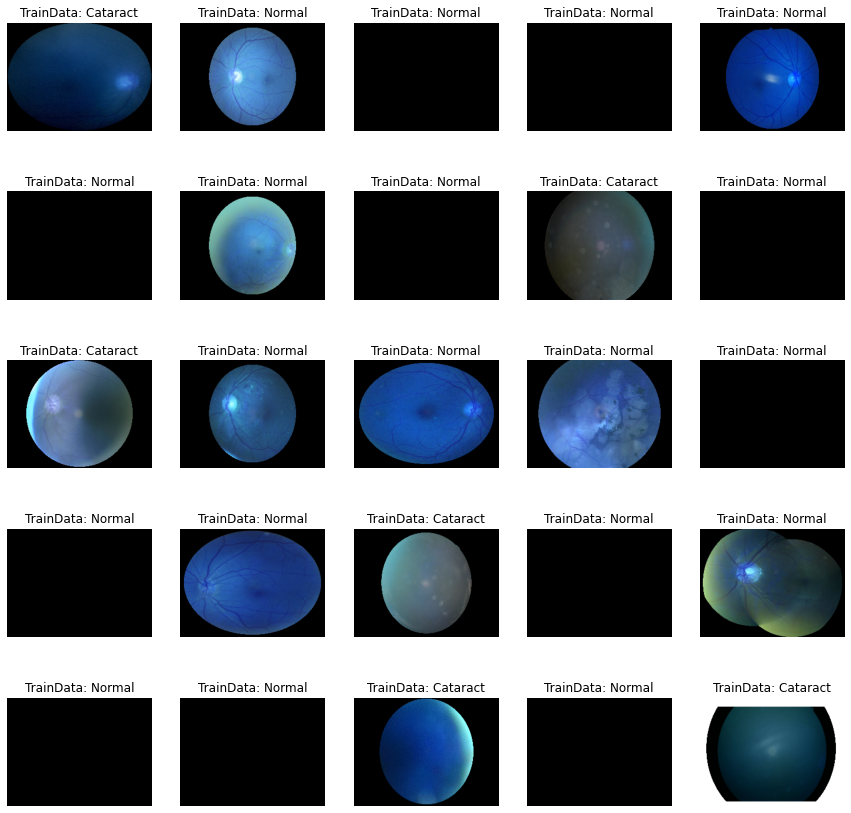

In [22]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

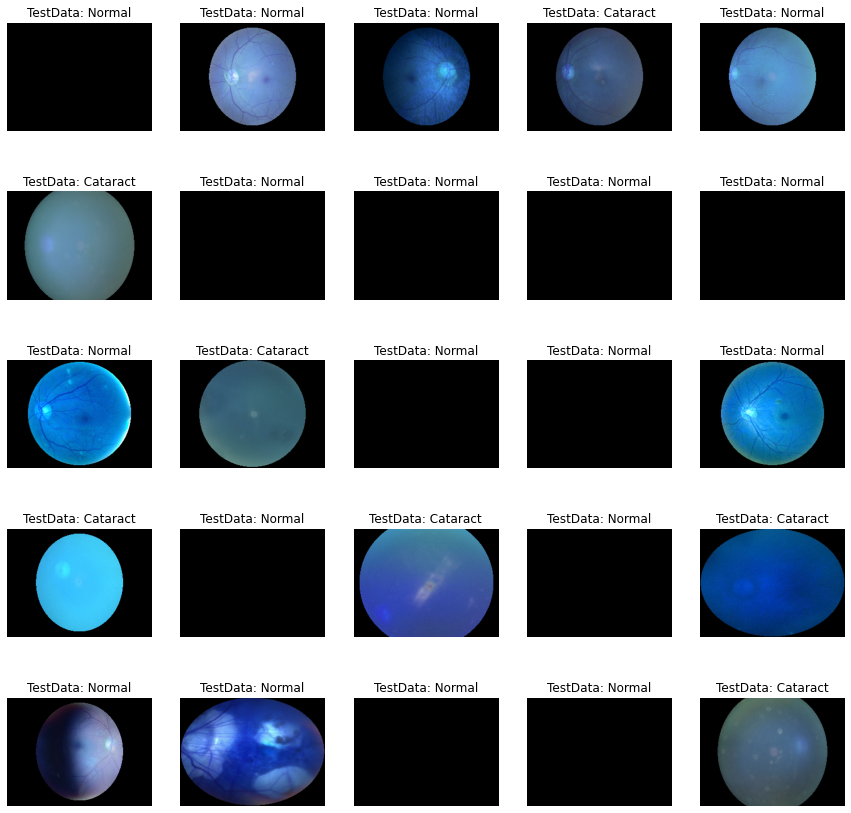

In [23]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

## Build the model(1) <a name="build1"> </a>

In [24]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [25]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 256, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 256, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 85, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 85, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 85, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 85, 16)        2

Use some image data augmentation to generate randomly augmented image data from the ImageDataGenerator Object.

In [26]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
26/26 [==============================] - 16s 318ms/step - loss: 2.0518 - accuracy: 0.7490 - val_loss: 0.7139 - val_accuracy: 0.2568
Epoch 2/100
26/26 [==============================] - 8s 317ms/step - loss: 0.7286 - accuracy: 0.7456 - val_loss: 0.7019 - val_accuracy: 0.7365
Epoch 3/100
26/26 [==============================] - 8s 324ms/step - loss: 1.7265 - accuracy: 0.7466 - val_loss: 1.7472 - val_accuracy: 0.2568
Epoch 4/100
26/26 [==============================] - 8s 312ms/step - loss: 0.7015 - accuracy: 0.8133 - val_loss: 1.3976 - val_accuracy: 0.2568
Epoch 5/100
26/26 [==============================] - 8s 311ms/step - loss: 0.7743 - accuracy: 0.7721 - val_loss: 1.3655 - val_accuracy: 0.2568
Epoch 6/100
26/26 [==============================] - 8s 316ms/step - loss: 0.7257 - accuracy: 0.7951 - val_loss: 2.0458 - val_accuracy: 0.2568
Epoch 7/100
26/26 [==============================] - 8s 315ms/step - loss: 0.8796 - accuracy: 0.8007 - val_loss: 3.4519 - val_accuracy: 0.256

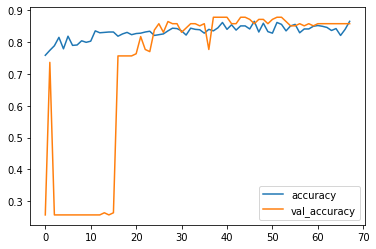

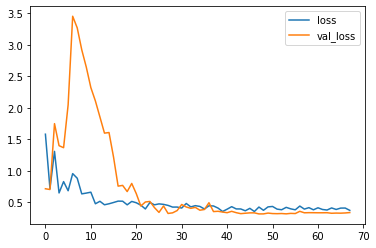

In [27]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [28]:
model.evaluate(test_imgs, test_df) 

8/8 [==============================] - 0s 35ms/step - loss: 0.3204 - accuracy: 0.8659


[0.3204319179058075, 0.8658536672592163]

In [ ]:
model.save(get_full_path('custom_model.h5'))

## Build the model(2) <a name="build2"> </a>
We will train using a model that has been pre-trained.

In [35]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 6, 8, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [30]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
26/26 [==============================] - 20s 470ms/step - loss: 0.7683 - accuracy: 0.3819 - val_loss: 0.8277 - val_accuracy: 0.2568
Epoch 2/100
26/26 [==============================] - 11s 412ms/step - loss: 0.6615 - accuracy: 0.6130 - val_loss: 0.7755 - val_accuracy: 0.2838
Epoch 3/100
26/26 [==============================] - 11s 415ms/step - loss: 0.6292 - accuracy: 0.6797 - val_loss: 0.8270 - val_accuracy: 0.3108
Epoch 4/100
26/26 [==============================] - 11s 413ms/step - loss: 0.5530 - accuracy: 0.7651 - val_loss: 0.7961 - val_accuracy: 0.2905
Epoch 5/100
26/26 [==============================] - 11s 416ms/step - loss: 0.5429 - accuracy: 0.7593 - val_loss: 0.7467 - val_accuracy: 0.2770
Epoch 6/100
26/26 [==============================] - 11s 416ms/step - loss: 0.4742 - accuracy: 0.8044 - val_loss: 0.7602 - val_accuracy: 0.3041
Epoch 7/100
26/26 [==============================] - 11s 414ms/step - loss: 0.4611 - accuracy: 0.8121 - val_loss: 0.7227 - val_accuracy:

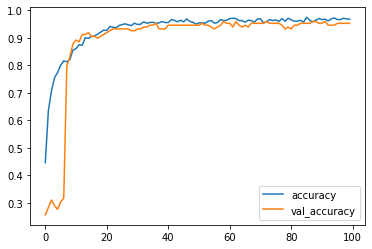

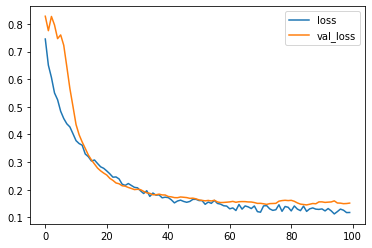

In [31]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [32]:
model.evaluate(test_imgs, test_df) 

8/8 [==============================] - 1s 88ms/step - loss: 0.1388 - accuracy: 0.9472


[0.1388092041015625, 0.9471544623374939]

In [34]:
model.save(get_full_path('efficientnet-b0_model.h5'))